In [2]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import urllib2

# Download data when running locally
!curl -O http://s3.amazonaws.com/stat-37601/pnas.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  763M  100  763M    0     0  1530k      0  0:08:30  0:08:30 --:--:-- 1844k


In [7]:
articles = sc.textFile('pnas.json', minPartitions=256).map(json.loads).cache()
print articles.count()
print articles.first()

13948
{u'body': u'<!DOCTYPE art SYSTEM "keton.dtd">\n<ART JID="PNAS" AID="0391" VID="94" ISS="14" DATE="07-08-1997" PPF="7633" PPL="7638">\n<FM>\n<DOCTOPIC>Neurobiology</DOCTOPIC>\n<DOCSUBJ>Biological Sciences</DOCSUBJ>\n<ATL>Transmembrane topology of a CLC chloride&thinsp;channel</ATL>\n<AUG>\n<AU><FNM>Thomas</FNM><SNM>Schmidt-Rose</SNM></AU>\n<AU><FNM>Thomas J.</FNM><SNM>Jentsch</SNM></AU>\n<FNR RID="FN151"><AFF>Center for Molecular Neurobiology Hamburg, ZMNH, Hamburg\nUniversity, Martinistrasse 52, D-20246 Hamburg, Germany</AFF>\n</AUG>\n<RE>February 13, 1997</RE>\n<ACC>May 12, 1997</ACC>\n<COM>William A. Catterall, University of Washington\nSchool of Medicine, Seattle, WA</COM>\n<PUBFRONT>\n<CPYRT><DATE><YEAR>1997</YEAR></DATE>\n<CPYRTNME><COLLAB>The National Academy of Sciences of the USA</COLLAB></CPYRTNME></CPYRT>\n<ISSN>0027-8424</ISSN><EXTENT>6</EXTENT><PRICE>2.00/0</PRICE>\n</PUBFRONT>\n<FN ID="FN151"><P>To whom reprint requests should be addressed.</P>\n</FN>\n<ABS><P>CLC ch

First, we parse the XML file. We do this by taking the section of text in the "BDY." Then we strip the text of unwanted characters.

In [8]:
import re
# Parses XML file to return body text
def parse(f):
    data_xml = f['body']
    beg = data_xml.find("<BDY>")
    end = data_xml.find("</BDY>")
    body_xml = data_xml[beg:end]
    
    # Strip unwanted characters
    exp = re.compile(r'<.*?>')
    text = exp.sub('',body_xml)
    p = '(){}[].,;&'
    for char in p: text = text.replace(char,"")
    text = text.lower()
    #print text
    return text

In [9]:
texts_rdd = articles.map(parse)
print texts_rdd.first()


voltage-gated chloride channels of the clc family are highly
conserved during evolution and are expressed in organisms ranging from
bacteria  and yeast  to plants  and animals  their
physiological functions in higher organisms include the regulation of
cell volume control of electrical excitability and transepithelial
transport
the clc proteins were identified by expression cloning of the
torpedo chloride channel clc-0  at present nine
mammalian members are known for review see ref  clc-1 is nearly
specific for skeletal muscle  it ensures its electrical stability
which is evident from clc-1 mutations leading to myotonia congenita a
disease characterized by defective muscle relaxation many different
clc-1 mutations were found in human myotonia and in animal models
 the importance of clc channels is underscored by another
recently identified disease inactivating mutations of clc-5 cause a
syndrome that is characterized by low molecular weight proteinuria
hypercalciuria and kidney stones

In [6]:
# Small test sample
test = articles.first()
test_text = parse(test)

Then we map and reduce Counter over the parsed rdd to rank words by frequency.

In [10]:
# Prints formatted dictionary
def print_dict(d):
    d_view = [(v,k) for k,v in d.iteritems()]
    d_view.sort(reverse=True)
    for c, w in d_view:
        print "%s: %d\n" % (w,c)

In [ ]:
from collections import Counter
counts_rdd = texts_rdd.map(lambda t: Counter(t.split()))
counts = counts_rdd.reduce(lambda a,b: a+b)
#texts_list = test_text.split()
#counts = Counter(texts_list)
print_dict(counts)

the: 3179730

of: 2248693

and: 1509179

in: 1410975

to: 941411

a: 933501

with: 594060

that: 521436

by: 519528

for: 500248

is: 475511

were: 457327

was: 437507

as: 329214

from: 315360

cells: 297426

at: 281696

are: 266797

or: 238870

this: 224355

on: 220931

fig: 211442

not: 199285

be: 189453

an: 174569

we: 159820

these: 154172

protein: 135002

cell: 132493

which: 127106

have: 119886

b: 117002

it: 108047

shown: 104016

expression: 101401

after: 100712

dna: 95671

two: 94766

also: 94160

using: 94032

been: 91586

mice: 90862

data: 90316

gene: 88733

1: 87716

between: 87675

=: 86738

activity: 84684

mm: 84049

used: 83502

has: 83376

proteins: 82495

both: 79413

c: 78428

but: 78349

all: 75468

other: 75387

results: 75189

may: 74689

each: 72857

into: 70776

can: 70650

than: 70265

binding: 68501

analysis: 67581

because: 66144

one: 65893

no: 65377

sequence: 62662

only: 61684

described: 59640

2: 59233

human: 55921

10: 54939

genes: 54417


Plot the frequency versus rank on a standard scale and on a log-log scale.

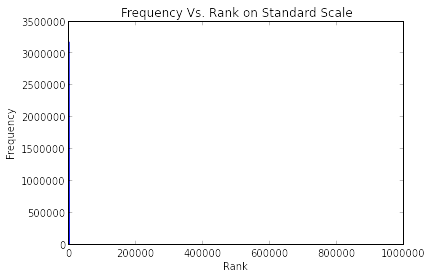

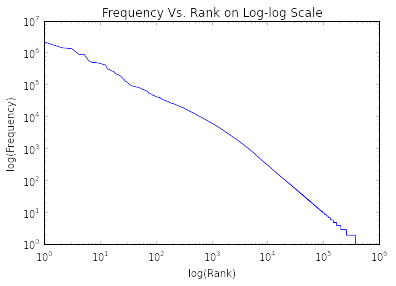

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(counts)), sorted(counts.values(),reverse=True))
plt.ylabel('Frequency')
plt.xlabel('Rank')
plt.title('Frequency Vs. Rank on Standard Scale')
plt.show()

ax = plt.gca()
ax.plot(range(len(counts)), sorted(counts.values(),reverse=True))
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel('log(Frequency)')
plt.xlabel('log(Rank)')
plt.title('Frequency Vs. Rank on Log-log Scale')
plt.show()

On the standard scale, a few words have a very high frequency, likely the stop words, and the frequency drops very rapidly over the rest of the words. On the log-log scale, we see that the plot does appear to follow Zipf's Law, since there is an approximately linear relationship. 

Next, we want to filter out stop words and rare words.  
Methodology: We import a text file of stop words and remove these stop words from the previous vocabulary dictionary. If the length of the vocabulary is greater than 50,000 words, then we take the first 50,000 words in the dictionary, sorted by their counts.

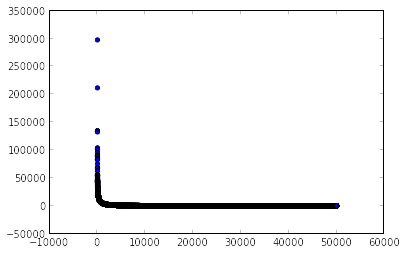

In [43]:
import urllib2
import collections
import itertools
#delete stop words from dictionary
response = urllib2.urlopen('http://algs4.cs.princeton.edu/35applications/stopwords.txt')
stopwords = response.read()
for w in stopwords.split():
    if w in counts:
        counts.pop(w, None)

#delete words of length 1 from dictionary
for w in counts.keys():
    if len(w)==1:
        counts.pop(w, None)

#filter out rare words from dictionary if dictionary is too big
if len(counts) > 50000:
    counts_list = counts.most_common(50000)

plt.scatter(range(len(counts_list)), zip(*counts_list)[1])
plt.show()

Write vocabulary to file pnasvocab.txt

In [44]:
vocab = zip(*counts_list)[0]
file = open("pnasvocab.txt", "w")
file.write('\n'.join(vocab))